In [679]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import random

import gzip, os, pickle # gzip for reading the gz files, pickle to save/dump trained model 
import _pickle as cPickle

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

# train-test split
from sklearn.model_selection import train_test_split

import time

# supress warnings
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [680]:
# reading the Treebank tagged sentences
data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [681]:
print('Number of Sentences in the corpus::',len(data),'\n')
# print first two tagged sentences
print(data[0:2])

Number of Sentences in the corpus:: 3914 

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [682]:
# Splitting into train and test
train_set, test_set = train_test_split(data,test_size=0.05, random_state=27)

In [683]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Number of tagged words in the training set::',len(train_tagged_words))

Number of tagged words in the training set:: 95475


In [684]:

#train_tagged_words = [(tup[0],'VBN') if (tup[1]=='VBD' and [i-1] not in('VP','VB'))  else tup for i,tup in enumerate(train_tagged_words)]#train_ta

In [685]:
#If a word X is '.' preceded by a 'cc' then '.' should be replaced by RB as conjuction(example 'and') can't come in end of the sentence. 

#train_tagged_words = [(tup[0],'RB') if (tup[1]=='.' and ([i-1]=='CC'))  else tup for i,tup in enumerate(train_tagged_words)]

In [686]:
#If a word X is preceded by a determiner and followed by a noun, tag it as an adjective (contextual rule). 

#train_tagged_words = [(tup[0],'JJ') if (([i-1]=='DT') and ([i+1] in('NN','NNP','NNS')))  else tup for i,tup in enumerate(train_tagged_words)]

In [687]:
# If a word ends with -ous, tag it as an adjective (morphological rule)
#train_tagged_words = [(tup[0],'JJ') if (tup[0].endswith('ous'))  else tup for tup in train_tagged_words]

In [688]:
# Vocabulary 
tokens = [pair[0] for pair in train_tagged_words]
V = set(tokens)
print('Number of unique words::',len(V),'\n')
print(tokens[0:10])

Number of unique words:: 12042 

['Nissan', 'Motor', 'Co.', ',', 'Japan', "'s", 'second-largest', 'car', 'maker', ',']


In [689]:
# Number of Tags
T = set([pair[1] for pair in train_tagged_words])
print('Number of tags::',len(T),'\n')
print(T)

Number of tags:: 12 

{'.', 'VERB', 'ADV', 'PRON', 'X', 'PRT', 'NUM', 'ADJ', 'CONJ', 'ADP', 'DET', 'NOUN'}


### POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [690]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [691]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [692]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [693]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [694]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,.,VERB,ADV,PRON,X,PRT,NUM,ADJ,CONJ,ADP,DET,NOUN
.,0.092172,0.088654,0.052579,0.065206,0.027507,0.002345,0.081710,0.044192,0.058532,0.091540,0.174333,0.221140
VERB,0.034523,0.168261,0.082031,0.035767,0.217790,0.031413,0.023326,0.064847,0.005598,0.091206,0.134982,0.110256
ADV,0.136470,0.343677,0.078412,0.016016,0.024024,0.014681,0.031698,0.128128,0.006673,0.118118,0.069069,0.033033
PRON,0.041186,0.485758,0.034642,0.008083,0.093918,0.012317,0.007313,0.071594,0.004619,0.021555,0.009623,0.209392
X,0.161563,0.205582,0.025678,0.054864,0.073844,0.185486,0.002711,0.017225,0.010686,0.144019,0.054864,0.063477
PRT,0.043222,0.402423,0.009496,0.018009,0.012443,0.001965,0.055992,0.085789,0.001965,0.020301,0.101506,0.246889
NUM,0.116307,0.017757,0.001776,0.001480,0.208642,0.026635,0.186150,0.032850,0.013318,0.035513,0.003255,0.356318
ADJ,0.064965,0.012264,0.004475,0.000663,0.021213,0.010772,0.020882,0.066291,0.016573,0.077395,0.004640,0.699867
CONJ,0.036061,0.156264,0.054092,0.059177,0.008784,0.005086,0.040222,0.116967,0.000462,0.054092,0.118816,0.349977
ADP,0.039902,0.008344,0.013800,0.069106,0.034446,0.001391,0.063222,0.106012,0.000856,0.017330,0.322957,0.322636


In [695]:
tags_df.loc['.', :]

.       0.092172
VERB    0.088654
ADV     0.052579
PRON    0.065206
X       0.027507
PRT     0.002345
NUM     0.081710
ADJ     0.044192
CONJ    0.058532
ADP     0.091540
DET     0.174333
NOUN    0.221140
Name: ., dtype: float32

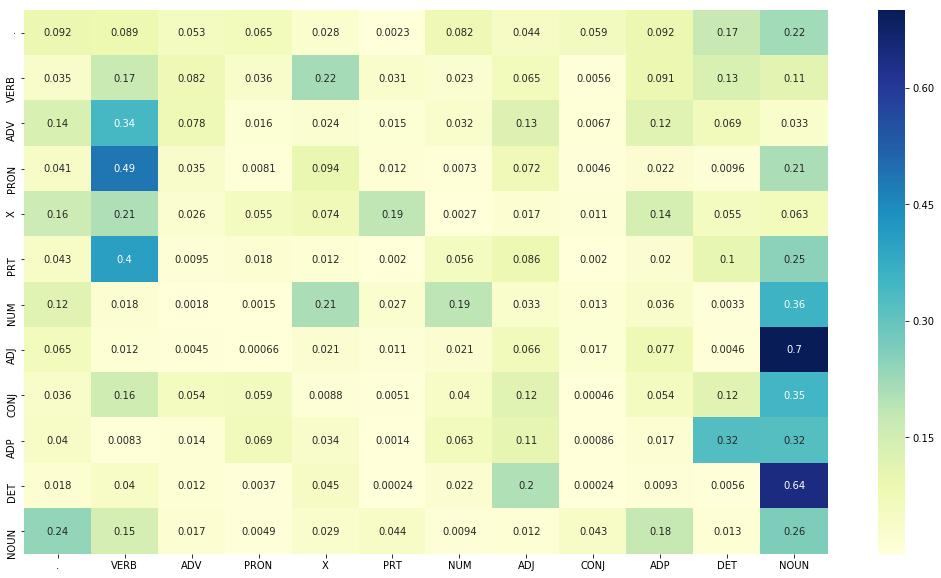

In [696]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 10))
sns.heatmap(tags_df, cmap="YlGnBu",annot=True)
plt.show()

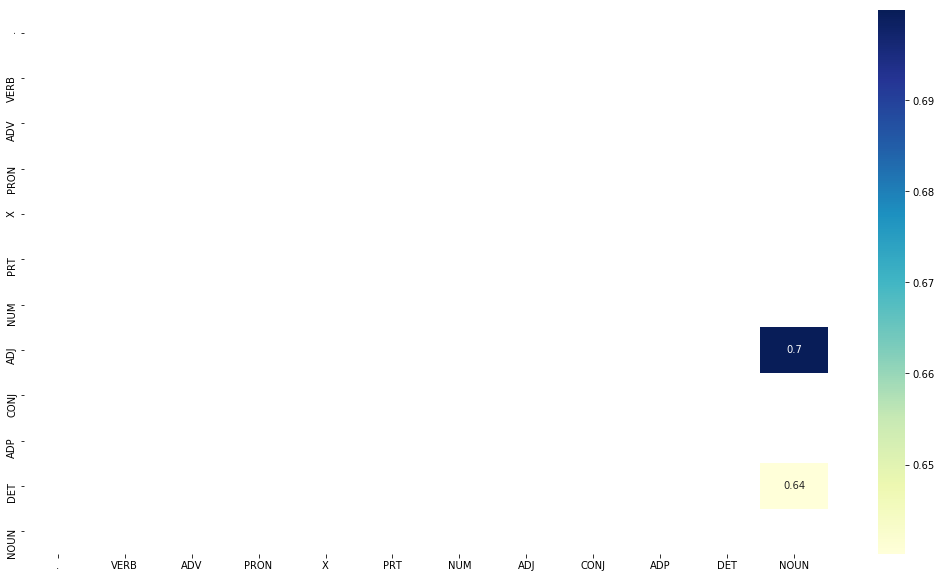

In [697]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 10))
sns.heatmap(tags_frequent, cmap="YlGnBu",annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [698]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Evaluation on Test Set
#### Running on entire test dataset would take more than 3-4hrs. 
#### So we will run Viterbi algorithm on 5 random sample sentences of test dataset

In [699]:
random.seed(27)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [582]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words) 
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference,'\n')
print('Tagged Reults','\n',tagged_seq[0:10])

Time taken in seconds:  22.390422105789185 

Tagged Reults 
 [('Sterling', 'NOUN'), ("'s", 'PRT'), ('firm', 'NOUN'), ('tone', 'NOUN'), (',', '.'), ('combined', 'VERB'), ('with', 'ADP'), ('a', 'DET'), ('steady', 'ADJ'), ('opening', 'VERB')]


### Accuracy

In [583]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.8936170212765957

### Incorrect Tagged Cases

In [584]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print('Incorrect Tagged words count',len(incorrect_tagged_cases),'\n')
incorrect_tagged_cases

Incorrect Tagged words count 15 



[[("'s", 'PRT'), (('firm', 'NOUN'), ('firm', 'ADJ'))],
 [('steady', 'ADJ'), (('opening', 'VERB'), ('opening', 'NOUN'))],
 [('also', 'ADV'), (('tempted', '.'), ('tempted', 'VERB'))],
 [('and', 'CONJ'), (('potentially', '.'), ('potentially', 'ADV'))],
 [('For', 'ADP'), (('starters', '.'), ('starters', 'NOUN'))],
 [('H.', 'NOUN'), (('Hudnut', '.'), ('Hudnut', 'NOUN'))],
 [('Indianapolis', 'NOUN'), (('Symphony', '.'), ('Symphony', 'NOUN'))],
 [('Symphony', 'NOUN'), (('Orchestra', '.'), ('Orchestra', 'NOUN'))],
 [('a', 'DET'), (('guest', '.'), ('guest', 'NOUN'))],
 [('guest', 'NOUN'),
  (('pianist-comedian', '.'), ('pianist-comedian', 'NOUN'))],
 [('pianist-comedian', 'NOUN'), (('Victor', '.'), ('Victor', 'NOUN'))],
 [('Victor', 'NOUN'), (('Borge', '.'), ('Borge', 'NOUN'))],
 [('from', 'ADP'), (('soured', '.'), ('soured', 'ADJ'))],
 [('something', 'NOUN'), (('structurally', '.'), ('structurally', 'ADV'))],
 [('and', 'CONJ'), (('radically', '.'), ('radically', 'ADV'))]]

### Rule Based changes to improve the performance.

The regular expression tagger assigns tags to tokens on the basis of matching patterns. For instance, we might guess that any word ending in ed is the past participle of a verb, and any word ending with 's is a possessive noun. We can express these as a list of regular expressions:

In [587]:
patterns = [
     (r'.*ing$', 'VBG'),               # gerunds
     (r'.*ed$', 'VBD'),                # simple past
     (r'.*es$', 'VBZ'),                # 3rd singular present
     (r'.*ould$', 'MD'),               # modals
     (r'.*\'s$', 'NN$'),               # possessive nouns
     (r'.*s$', 'NNS'),                 # plural nouns
     (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
     (r'.*', 'NN')                     # nouns (default)
 ]

The final regular expression «.*» is a catch-all that tags everything as a noun.

In [595]:
regexp_tagger = nltk.RegexpTagger(patterns)

### Unigram Tagging
Unigram taggers are based on a simple statistical algorithm: for each token, assign the tag that is most likely for that particular token. For example, it will assign the tag JJ to any occurrence of the word _frequent_, since _frequent_ is used as an adjective (e.g. a _frequent_ word) more often than it is used as a verb (e.g. I _frequent_ this cafe). A unigram tagger behaves just like a lookup tagger (4), except there is a more convenient technique for setting it up, called training. In the following code sample, we train a unigram tagger, use it to tag a sentence, then evaluate:

In [700]:
unigram_tagger = nltk.UnigramTagger(train_set)
#unigram_tagger.evaluate(test_set)

### N-Gram Tagging
An n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding tokens.

In [701]:
bigram_tagger = nltk.BigramTagger(train_set)
#bigram_tagger.evaluate(test_set)

### Combining Taggers
One way to address the trade-off between accuracy and coverage is to use the more accurate algorithms when we can, but to fall back on algorithms with wider coverage when necessary. For example, we could combine the results of a bigram tagger, a unigram tagger, and a default tagger, as follows:

    1. Try tagging the token with the bigram tagger.
    2. If the bigram tagger is unable to find a tag for the token, try the unigram tagger.
    3. If the unigram tagger is also unable to find a tag, use a default tagger.

In [702]:
combo_tagger = nltk.UnigramTagger(train_set, backoff=regexp_tagger)

### Modification in Viterbi algorithm to incorporate the above changes

In [703]:
def Viterbi_Advance(words, train_bag = train_tagged_words, tagger=3):
    """
    tagger = 0 for defaul Viterbi Algorithm
             1 for Unigram Tagger
             2 for Bigram Tagger
             3 for Rule Based Tagged
             4 for Combination taggers(combination of Unigram & Rule-based )-default
    """
    UnknownTags='' 
        
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    wordsSet = set([pair[0] for pair in train_bag])
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        if tagger == 1:
            UnknownTags = unigram_tagger.tag([word])[0][1]
        elif tagger == 2:
            UnknownTags = bigram_tagger.tag([word])[0][1]
        elif tagger == 3:
            UnknownTags = regexp_tagger.tag([word])[0][1] 
        elif tagger == 4:
            UnknownTags = combo_tagger.tag([word])[0][1]
        else:
            UnknownTags = bigram_tagger.tag([word])[0][1] 
        
        unknownWord = word  not in  wordsSet   
            
       
        for tag in T:
            if((unknownWord == True) and (tagger!=0)):
                if ( tag == UnknownTags):
                    state_probability = 1;
                else:
                    state_probability = 0
                                   
            else:
                                       
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                    # compute emission and state probabilities
                result = word_given_tag(words[key], tag)
                #emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                emission_p = result[0]/result[1]
                state_probability = emission_p * transition_p   
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [705]:
# tagging the test sentences
start = time.time()


tagged_seq = Viterbi_Advance(test_tagged_words,tagger=3)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
#print(tagged_seq)
#print(test_run_base)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("The percentage accuracy is ",accuracy )
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

print("The number of incorrectly tag words is:")
print(len(incorrect_tagged_cases))

Time taken in seconds:  10.554118871688843
The percentage accuracy is  0.8936170212765957
The number of incorrectly tag words is:
15
